In [1]:
from hvv2.common import HVNode
from hvv2.encoder import HVEncoder
from hvv2.decoder import HVDecoder
from hvv2.serialization import HVDeserializer, HVSerializer
import utils
from decoder import Decoder as BruteForceDecoder
from jit_bfencoder import JitedBruteForceEncoder

import os
import io
import numpy as np
import pandas as pd
import itertools as it
from matplotlib import pyplot as plt
from PIL import Image
from dataclasses import dataclass
from time import time
from typing import Callable, Any
from tqdm import tqdm
import plotly.express as px
from quadtree.decoder import AUTO

In [2]:
def load_img(path: str) -> np.ndarray:
    return utils.load_grayscale(path)

def kalafior(size: int) -> np.ndarray:
    return load_img(f'../imgs/raw/cauliflower_{size}x{size}.png')

def rectangular_kalafior(width: int, height: int) -> np.ndarray:
    return load_img(f'../imgs/raw/cauliflower_{width}x{height}_colored.png')

def lena(size: int):
    return load_img(f'../imgs/raw/lena_{size}x{size}_grayscale.bmp')

def rectangular_lena(width: int, height: int) -> np.ndarray:
    return load_img(f'../imgs/raw/lena_{width}x{height}_colored.bmp')

def save_grayscale(src_path: str, dest_path: str):
    with Image.open(src_path) as im:
        im_gray = im.convert("L")
        im_gray.save(dest_path)

def show_img(img: np.ndarray, ax):
    ax.imshow(img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

def load_rgb_img(path: str) -> np.ndarray:
    with Image.open(path) as im:
        return np.array(im.convert("RGB"))
    
def colored_kalafior(size: int):
    return load_rgb_img(f'./../imgs/raw/cauliflower_{size}x{size}_colored.png')
    
def colored_lena(size: int):
    return load_rgb_img(f'./../imgs/raw/lena_{size}x{size}_colored.bmp')

def show_img_colored(img: np.ndarray, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])

In [3]:
@dataclass
class CodecInfo:
    encoding: Any
    decoded_img: np.ndarray
    encoding_time: float
    decoding_time: float
    decoding_iterations: int

def encode_decode_jpeg(img: np.ndarray) -> CodecInfo:
    with io.BytesIO() as bytes_io:
        start = time()
        if len(img.shape) == 2:
            Image.fromarray(img).save(bytes_io, format="JPEG")
        else:
            Image.fromarray(img).convert('RGB').save(bytes_io, format="JPEG")
        encoding_time = time() - start

        start = time()
        bytes_io.seek(0)
        decoded_img = np.asarray(Image.open(bytes_io))
        decoding_time = time() - start
    return CodecInfo(None, decoded_img, encoding_time, decoding_time, 0)

In [4]:
def encode_decode_bruteforce(img: np.ndarray, decoding_iterations=32, show_error_stats=False) -> CodecInfo:
    start = time()
    encoder = JitedBruteForceEncoder(img)
    encoded_img, errs = encoder.encode()
    encoding_time = time() - start

    start = time()
    decoder = BruteForceDecoder()
    decoded_img = decoder.decode(encoded_img, iterations=decoding_iterations)
    decoding_time = time() - start

    if show_error_stats:
        plt.hist(errs)

    return CodecInfo(encoded_img, decoded_img, encoding_time, decoding_time, decoding_iterations)

In [7]:
def encode_decode_hv(img: np.ndarray, encoder: HVEncoder=None, decoding_iterations=AUTO) -> CodecInfo:
    if encoder is None:
        encoder = HVEncoder(4, 4, 32, 32, 7, 5, 4., 1.)
    start = time()
    encoded_img = encoder.encode(img)
    encoding_time = time() - start
    print(f"Encoding finished in {encoding_time}")

    start = time()
    decoded_img = HVDecoder(decoding_iterations, stop_on_relative_error=5e-4, log_stop=True).decode(encoded_img)
    decoding_time = time() - start
    print(f"Decoding finished in {decoding_time}")

    return CodecInfo(encoded_img, decoded_img, encoding_time, decoding_time, decoding_iterations)

In [8]:
@dataclass
class Metrics:
    squared_error: float
    mse: float
    psnr: float
    encoding_time: str
    decoding_time: str

def compute_metrics(original_img: np.ndarray, codec_info: CodecInfo) -> Metrics:
    squared_error = np.linalg.norm(original_img.astype(np.int32) - codec_info.decoded_img.astype(np.int32))
    mse = squared_error / np.prod(original_img.shape)
    psnr = 10 * np.log10(255. / mse)
    return Metrics(squared_error, mse, psnr, f'{codec_info.encoding_time:.4f}s', f'{codec_info.decoding_time:.4f}s')

def compare_encoding(original_img: np.ndarray, codec_info: CodecInfo):
    jpeg_info = encode_decode_jpeg(original_img)
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f"Image size: {original_img.shape[1]}x{original_img.shape[0]}")
    imgs = [original_img, codec_info.decoded_img, jpeg_info.decoded_img]
    titles = ["Original", "Fractal compressed", "JPEG compressed"]
    for ax, img, title in zip(axs, imgs, titles):
        if len(img.shape) == 3:
            show_img_colored(img, ax)
        else:
            show_img(img, ax)
        ax.set_title(title)
    plt.show()

    print('Fractal compression:')
    print(compute_metrics(original_img, codec_info))

    print('JPEG (PIL defaults):')
    print(compute_metrics(original_img, jpeg_info))

In [7]:
# img = kalafior(128)
# bruteforce_encoding = encode_decode_bruteforce(img, show_error_stats=True)
# compare_encoding(img, bruteforce_encoding)

Encoding finished in 2151.3650426864624
Auto decoding stopped after 8 iterations
Decoding finished in 0.7738580703735352


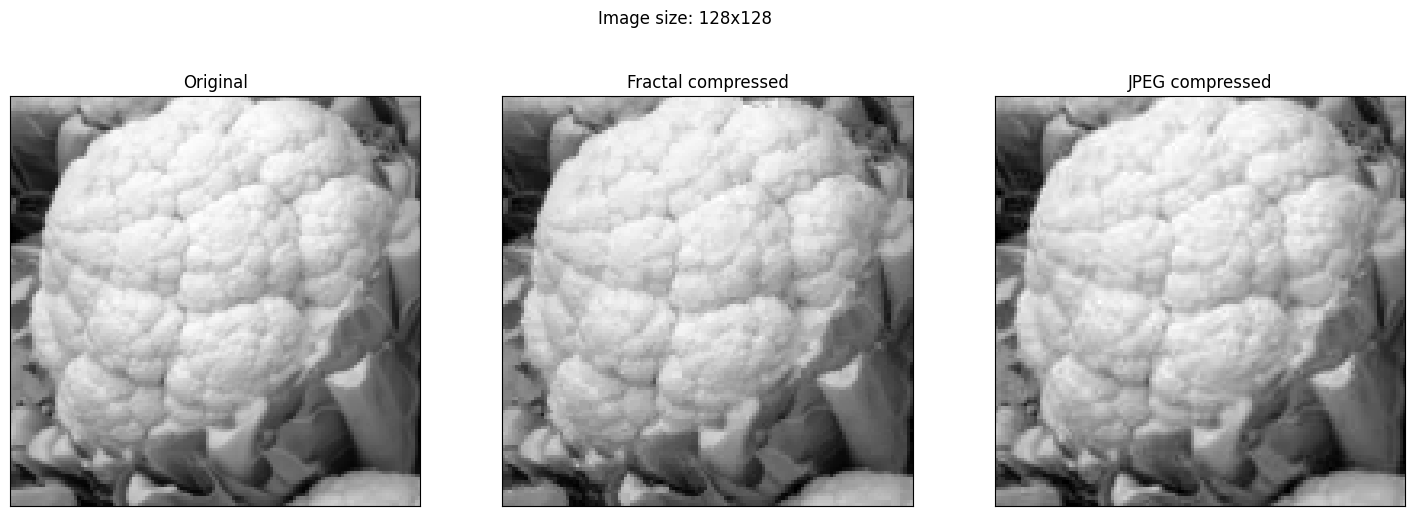

Fractal compression:
Metrics(squared_error=613.7727592521519, mse=0.037461716262948724, psnr=38.329525102656945, encoding_time='2151.3650s', decoding_time='0.7739s')
JPEG (PIL defaults):
Metrics(squared_error=541.4065016233181, mse=0.0330448304213451, psnr=38.87436652923619, encoding_time='0.1323s', decoding_time='0.0814s')


In [13]:
# example 1

def small_img(size: int = 128) -> np.ndarray:
    # path = "imgs\\raw\\cauliflower_64x64_colored.png"
    return load_img(f'../imgs/raw/cauliflower_{size}x{size}_colored.png')
    # return load_img(path)


img = small_img()
hv_info = encode_decode_hv(img)
compare_encoding(img, hv_info)

In [ ]:
img = lena(256)
hv_info = encode_decode_hv(img)
compare_encoding(img, hv_info)